# Brain Observatory - Neuropixels

This notebook will introduce you to the Neuropixel dataset and SDK functions.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The main entry point is the `EcephyProjectCache` class. This class is
responsible for downloading any requested data or metadata as needed and storing
it in well known locations. For this workshop, all of the data has been
preloaded onto the hard drives you have received, and is available on AWS.

We begin by importing the `EcephysProjectCache` class and instantiating it.

`manifest_path` is a path to the manifest file. We will use the manifest file
preloaded onto your Workshop hard drives. Make sure that `drive_path` is set
correctly for your platform. (See the first cell in this notebook.)

In [2]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session

cache = EcephysProjectCache.from_warehouse()

## Exploring available sessions of the dataset

:::{admonition} Example: Get information about what's in the Neuropixels dataset

Use the `get_sessions` function from `EcephysProjectCache` to retrieve a
dataframe of all the available sessions. What information does this dataframe
contain?

* How many sessions are there in the dataset?
* What is the average number of units in an experiment? The max number? The minimum?
* What are the different genotypes that were used in these experiments? How many sessions per genotype?
* What are all the brain structures that data has been collected from?
:::

In [3]:
sessions = cache.get_session_table()

In [4]:
sessions.head()

published_at  specimen_id           session_type  \
id                                                                    
715093703  2019-10-03T00:00:00Z    699733581  brain_observatory_1.1   
719161530  2019-10-03T00:00:00Z    703279284  brain_observatory_1.1   
721123822  2019-10-03T00:00:00Z    707296982  brain_observatory_1.1   
732592105  2019-10-03T00:00:00Z    717038288  brain_observatory_1.1   
737581020  2019-10-03T00:00:00Z    718643567  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
715093703        118.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
719161530        122.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
721123822        125.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
732592105        100.0   M                                            wt/wt   
737581020        108.0   M                                            wt/wt   

           unit_count  channel_count  probe_count  \
id                                                  
715093703         884           2219            6   
719161530         755           2214            6   
721123822         444           2229            6   
732592105         824           1847            5   
737581020         568           2218            6   

                                  ecephys_structure_acronyms  
id                                                            
715093703  [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...  
719161530  [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N...  
721123822  [MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ...  
732592105       [grey, VISpm, nan, VISp, VISl, VISal, VISrl]  
737581020      [grey, VISmma, nan, VISpm, VISp, VISl, VISrl]

How many sessions are available?

In [5]:
sessions.shape[0]

58

What's the average number of units in a session? The max? The min?

In [6]:
print(sessions.unit_count.mean())
print(sessions.unit_count.max())
print(sessions.unit_count.min())

689.8275862068965
1005
415


Text(0, 0.5, '# sessions')

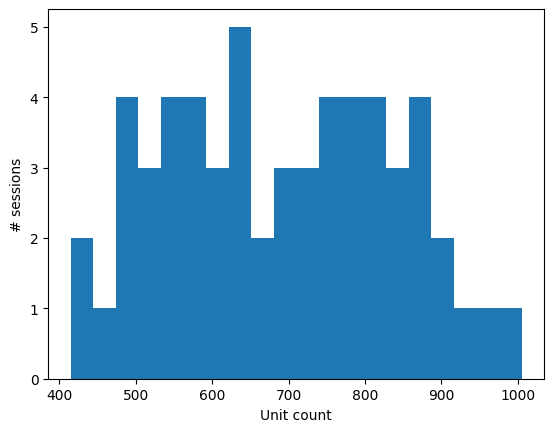

In [7]:
plt.hist(sessions.unit_count, bins=20);
plt.xlabel("Unit count")
plt.ylabel("# sessions")

What are the different genotypes that were used for this dataset? How many
sessions per genotype are available?

In [8]:
sessions.full_genotype.value_counts()

wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Name: full_genotype, dtype: int64

What are the different session types? How many sessions per type?

In [9]:
sessions.session_type.value_counts()

brain_observatory_1.1      32
functional_connectivity    26
Name: session_type, dtype: int64

What are all the structures that data has been collected from?

In [10]:
all_areas = []
for index,row in sessions.iterrows():
    for a in row.ecephys_structure_acronyms:
        if a not in all_areas:
            all_areas.append(a)

In [11]:
print(all_areas)

['CA1', 'VISrl', nan, 'PO', 'LP', 'LGd', 'CA3', 'DG', 'VISl', 'PoT', 'VISp', 'grey', 'VISpm', 'APN', 'MB', 'VISam', 'TH', 'Eth', 'POL', 'NOT', 'SUB', 'VL', 'CA2', 'VPM', 'VISal', 'SCig', 'PPT', 'VIS', 'ProS', 'LGv', 'HPF', 'VISmma', 'PP', 'PIL', 'MGv', 'VPL', 'IGL', 'SGN', 'IntG', 'LD', 'MGm', 'MGd', 'POST', 'MRN', 'VISli', 'OP', 'ZI', 'VISmmp', 'PF', 'LT', 'RPF', 'PRE', 'SCiw', 'CP', 'COAa', 'RT', 'SCop', 'SCsg', 'SCzo', 'COApm', 'OLF', 'BMAa']


To get more information about these structures, visit
[our reference atlas web app](http://atlas.brain-map.org/atlas?atlas=602630314).

How many sessions have data from VISp?

In [12]:
count=0
for index,row in sessions.iterrows():
    if 'VISp' in row.ecephys_structure_acronyms:
        count+=1
print(count)

56


## The session object
The session object contains all the data and metadata for a single experiment
session, including spike times, stimulus information, unit waveforms and derived
metrics, LFP, and the mouse's running speed.

The session object is accessed using `cache.get_session_data(session_id)`

:::{note}
Experiment data is loaded upon initialization of the class. Some data can be
accessed directly as an attribute of the class, others by using 'get' functions.
:::

:::{admonition} Example: Select a session
Let's pick one session to examine in greater detail. Select a
`brain_observatory_1.1` session. Feel free to use other metadata to select one
session and get the session_id (the index).
:::

In [13]:
session_id = sessions[(sessions.unit_count>900)&(sessions.session_type=='brain_observatory_1.1')
                      &(sessions.full_genotype=='wt/wt')].index[0]
print(session_id)

750332458


Which areas were recorded from in this session?

In [14]:
sessions.ecephys_structure_acronyms[session_id]

array(['grey', 'VISrl', nan, 'VISal', 'IntG', 'IGL', 'LGd', 'CA3', 'DG',
       'CA1', 'VISl', 'VISp', 'VISpm', 'VISam'], dtype=object)

:::{admonition} Example: Get the data for this session.

Use the `get_session_data` function of the cache to get the session object for
this session. This object contains the data that is stored in the NWB file.
:::

In [15]:
session = cache.get_session_data(session_id)

## Units

 The primary data in this dataset is the recorded acrtivity of isolated units. A
 number of metrics are used to isolate units through spike sorting, and these
 metrics can be used to access how well isolated they are and the quality of
 each unit. The `units` dataframe provides many of these metrics, as well as
 parameterization of the waveform for each unit that passed initial QC,
 including

* **firing rate:** mean spike rate during the entire session
* **presence ratio:** fraction of session when spikes are present
* **ISI violations:** rate of refractory period violations
* **Isolation distances:** distance to nearest cluster in Mihalanobis space
* **d':** classification accuracy based on LDA
* **SNR:** signal to noise ratio
* **Maximum drift:** Maximum change in spike depth during recording
* **Cumulative drift:** Cumulative change in spike depth during recording

**1D Waveform features:**

```{image} ../../resources/spike_waveform.png
:name: spike-waveform
```

For more information on these:

https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/quality_metrics
https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms


:::{admonition} Example: Units
Get the `units` dataframe for this session.

What the the metrics? (i.e. what are the columns for the dataframe?

How many units are there? How many units per structure?
:::

In [16]:
session.units.head()

waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
unit_id                                                              
951817231           0.293351          101.641410          0.001248   
951817222           1.427508           74.654970          0.032535   
951817272           0.240866          182.350545          0.000218   
951817282           0.650177          183.182025          0.000223   
951817316           0.387017           71.279130          0.059431   

           cluster_id  cumulative_drift   d_prime  firing_rate  \
unit_id                                                          
951817231           8            392.48  6.461795    15.773666   
951817222           7            948.33  5.638511     6.423025   
951817272          13            578.80  4.865528    25.891454   
951817282          14            545.47  4.402664     9.177656   
951817316          18            446.09  3.582546    10.277127   

           isi_violations  isolation_distance   L_ratio  ...  \
unit_id                                                  ...   
951817231        0.020093          147.423046  0.000259  ...   
951817222        0.007457           95.080849  0.000727  ...   
951817272        0.002123          121.137882  0.017477  ...   
951817282        0.001370           59.655811  0.025102  ...   
951817316        0.050247           56.080395  0.021113  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
951817231                   8.0                       grey   
951817222                   8.0                       grey   
951817272                   8.0                       grey   
951817282                   8.0                       grey   
951817316                   8.0                       grey   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
951817231                                NaN                            NaN   
951817222                                NaN                            NaN   
951817272                                NaN                            NaN   
951817282                                NaN                            NaN   
951817316                                NaN                            NaN   

           left_right_ccf_coordinate  probe_description  \
unit_id                                                   
951817231                        NaN             probeA   
951817222                        NaN             probeA   
951817272                        NaN             probeA   
951817282                        NaN             probeA   
951817316                        NaN             probeA   

                          location  probe_sampling_rate  \
unit_id                                                   
951817231  See electrode locations         29999.968724   
951817222  See electrode locations         29999.968724   
951817272  See electrode locations         29999.968724   
951817282  See electrode locations         29999.968724   
951817316  See electrode locations         29999.968724   

           probe_lfp_sampling_rate  probe_has_lfp_data  
unit_id                                                 
951817231              1249.998697                True  
951817222              1249.998697                True  
951817272              1249.998697                True  
951817282              1249.998697                True  
951817316              1249.998697                True  

[5 rows x 40 columns]

In [17]:
session.units.columns

Index(['waveform_PT_ratio', 'waveform_amplitude', 'amplitude_cutoff',
       'cluster_id', 'cumulative_drift', 'd_prime', 'firing_rate',
       'isi_violations', 'isolation_distance', 'L_ratio', 'local_index',
       'max_drift', 'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id',
       'presence_ratio', 'waveform_recovery_slope',
       'waveform_repolarization_slope', 'silhouette_score', 'snr',
       'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below',
       'waveform_duration', 'filtering', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym', 'ecephys_structure_id',
       'ecephys_structure_acronym', 'anterior_posterior_ccf_coordinate',
       'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate',
       'probe_description', 'location', 'probe_sampling_rate',
       'probe_lfp_sampling_rate', 'probe_has_lfp_data'],
      dtype='object')

How many units are in this session?

In [18]:
session.units.shape[0]

902

Which areas (structures) are they from?

In [19]:
print(session.units.ecephys_structure_acronym.unique())

['grey' 'VISam' 'VISpm' 'VISp' 'IntG' 'IGL' 'LGd' 'CA3' 'DG' 'CA1' 'VISl'
 'VISal' 'VISrl']


How many units per area are there?

In [20]:
session.units.ecephys_structure_acronym.value_counts()

grey     558
VISal     71
VISp      63
VISam     60
VISrl     44
VISl      38
VISpm     19
CA1       16
CA3       15
DG         7
IGL        5
LGd        4
IntG       2
Name: ecephys_structure_acronym, dtype: int64

:::{admonition} Example: Select 'good' units
A default is to include units that have a SNR greater than 1 and ISI violations
less than 0.5 Plot a histogram of the values for each of these metrics? How
many units meet these criteria? How many per structure?
:::


plot a histogram for SNR

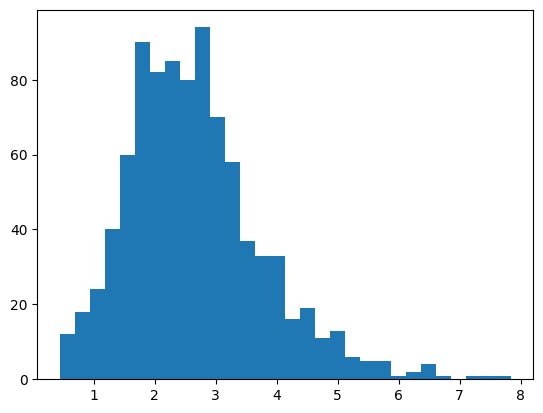

In [21]:
plt.hist(session.units.snr, bins=30);

plot a histogram for ISI violations

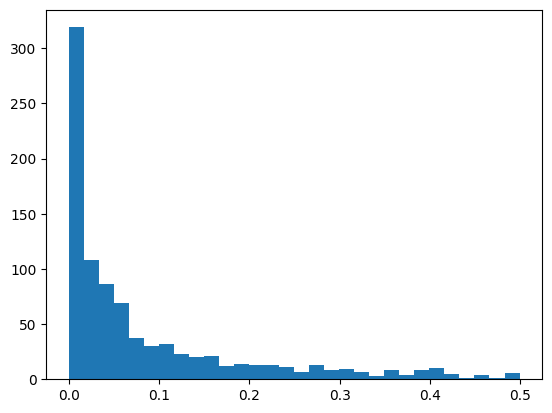

In [22]:
plt.hist(session.units.isi_violations, bins=30);

In [23]:
good_units = session.units[(session.units.snr>1)&(session.units.isi_violations<0.5)]
len(good_units)

868

In [24]:
good_units.ecephys_structure_acronym.value_counts()

grey     548
VISal     64
VISp      62
VISam     60
VISrl     37
VISl      34
VISpm     18
CA3       15
CA1       15
DG         7
IGL        4
LGd        3
IntG       1
Name: ecephys_structure_acronym, dtype: int64

:::{admonition} Example: Compare the firing rate of good units in different structures
Make a violinplot of the overall firing rates of units across structures.
:::

In [25]:
import seaborn as sns

<AxesSubplot:xlabel='ecephys_structure_acronym', ylabel='firing_rate'>

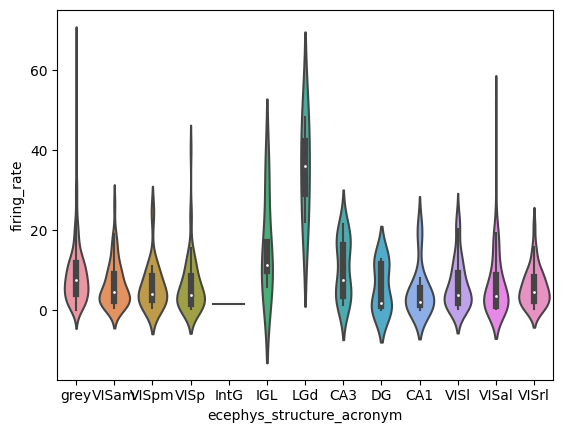

In [26]:
sns.violinplot(y='firing_rate', x='ecephys_structure_acronym',data=good_units)

:::{admonition} Example: Plot the location of the units on the probe
Color each structure a different color. What do you learn about the vertical position values?
:::

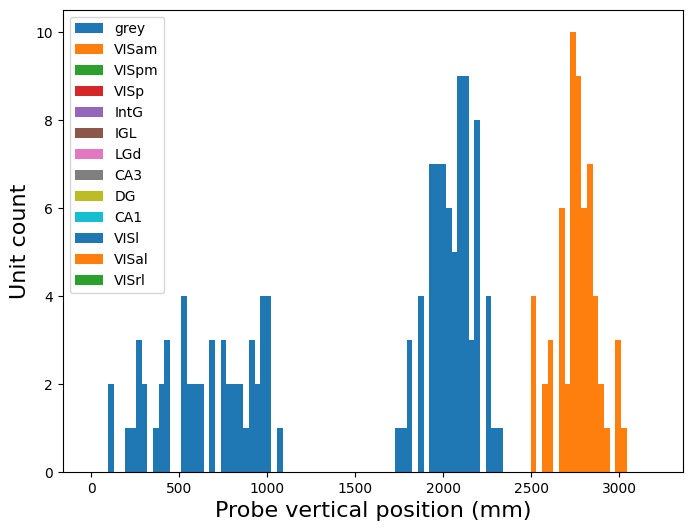

In [27]:
plt.figure(figsize=(8,6))
# restrict to one probe
probe_id = good_units.probe_id.values[0]
probe_units = good_units[good_units.probe_id==probe_id]
for structure in good_units.ecephys_structure_acronym.unique():
    plt.hist(
        probe_units[probe_units.ecephys_structure_acronym==structure].probe_vertical_position.values,
        bins=100, range=(0,3200), label=structure
    )
plt.legend()
plt.xlabel('Probe vertical position (mm)', fontsize=16)
plt.ylabel('Unit count', fontsize=16)
plt.show()

### Spike Times

The primary data in this dataset is the recorded acrtivity of isolated units.
The `spike times` is a dictionary of spike times for each units in the session.

:::{admonition} Example: Spike Times
Next let's find the `spike_times` for these units.
:::

In [28]:
spike_times = session.spike_times

What type of object is this?

In [29]:
type(spike_times)

dict

How many items does it include?

In [30]:
len(spike_times)

902

In [31]:
len(session.units)

902

What are the keys for this object?

In [32]:
list(spike_times.keys())[:5]

[951817566, 951817557, 951818568, 951818561, 951818553]

These keys are unit ids. Use the unit_id for the first unit to get the spike times for that unit. How many spikes does it have in the entire session?

In [33]:
spike_times[session.units.index[0]]

array([3.79596714e+00, 3.81646716e+00, 3.84250052e+00, ...,
       9.75020103e+03, 9.75023709e+03, 9.75027469e+03])

In [34]:
print(len(spike_times[session.units.index[0]]))

153738


:::{admonition} Example: Get the spike times for the units in V1
Use the units dataframe to identify units in 'VISp' and use the spike_times to
get their spikes. Start just getting the spike times for the first unit
identified this way. Plot a raster plot of the spikes during the first 5
minutes (300 seconds) of the experiment.
:::

In [35]:
session.units[session.units.ecephys_structure_acronym=='VISp'].head()

waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
unit_id                                                              
951814973           0.599534           26.217945          0.014322   
951814989           0.366990           43.292340          0.026720   
951816812           0.394103          103.924470          0.002891   
951815078           0.329370          111.679035          0.051784   
951815150           0.526429          232.830975          0.001259   

           cluster_id  cumulative_drift   d_prime  firing_rate  \
unit_id                                                          
951814973         361            345.26  2.927932     1.503416   
951814989         363            386.49  5.082127     1.885503   
951816812         561            146.34  4.708563     2.415644   
951815078         373            165.93  3.799649     4.062188   
951815150         382            302.18  6.045597     0.516495   

           isi_violations  isolation_distance   L_ratio  ...  \
unit_id                                                  ...   
951814973        0.410801           61.132264  0.001457  ...   
951814989        0.000000           89.588334  0.001691  ...   
951816812        0.046132           80.151626  0.000185  ...   
951815078        0.100211           55.356604  0.010204  ...   
951815150        0.000000           80.501412  0.000006  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
951814973                 385.0                       VISp   
951814989                 385.0                       VISp   
951816812                 385.0                       VISp   
951815078                 385.0                       VISp   
951815150                 385.0                       VISp   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
951814973                                NaN                            NaN   
951814989                                NaN                            NaN   
951816812                                NaN                            NaN   
951815078                                NaN                            NaN   
951815150                                NaN                            NaN   

           left_right_ccf_coordinate  probe_description  \
unit_id                                                   
951814973                        NaN             probeC   
951814989                        NaN             probeC   
951816812                        NaN             probeC   
951815078                        NaN             probeC   
951815150                        NaN             probeC   

                          location  probe_sampling_rate  \
unit_id                                                   
951814973  See electrode locations         29999.996461   
951814989  See electrode locations         29999.996461   
951816812  See electrode locations         29999.996461   
951815078  See electrode locations         29999.996461   
951815150  See electrode locations         29999.996461   

           probe_lfp_sampling_rate  probe_has_lfp_data  
unit_id                                                 
951814973              1249.999853                True  
951814989              1249.999853                True  
951816812              1249.999853                True  
951815078              1249.999853                True  
951815150              1249.999853                True  

[5 rows x 40 columns]

In [36]:
unit_id = session.units[session.units.ecephys_structure_acronym=='VISp'].index[12]

Text(0.5, 0, 'Time (s)')

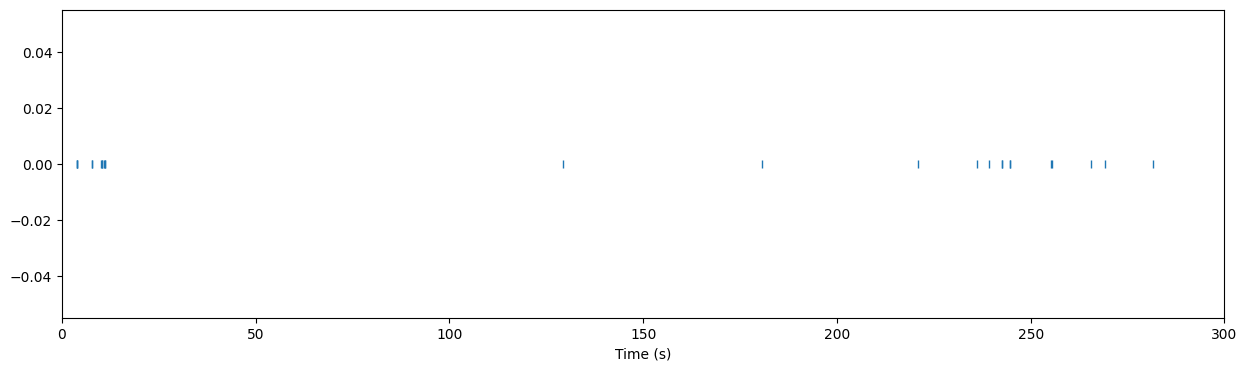

In [37]:
spikes = spike_times[unit_id]
plt.figure(figsize=(15,4))
plt.plot(spikes, np.repeat(0,len(spikes)), '|')
plt.xlim(0,300)
plt.xlabel("Time (s)")

:::{admonition} Example: Plot the firing rate for this units across the entire session
A raster plot won't work for visualizing the activity across the entire session
as there are too many spikes! Instead, bin the activity in 1 second bins.
:::

In [38]:
numbins = int(np.ceil(spikes.max()))
binned_spikes = np.empty((numbins))
for i in range(numbins):
    binned_spikes[i] = len(spikes[(spikes>i)&(spikes<i+1)])

Text(0, 0.5, 'FR (Hz)')

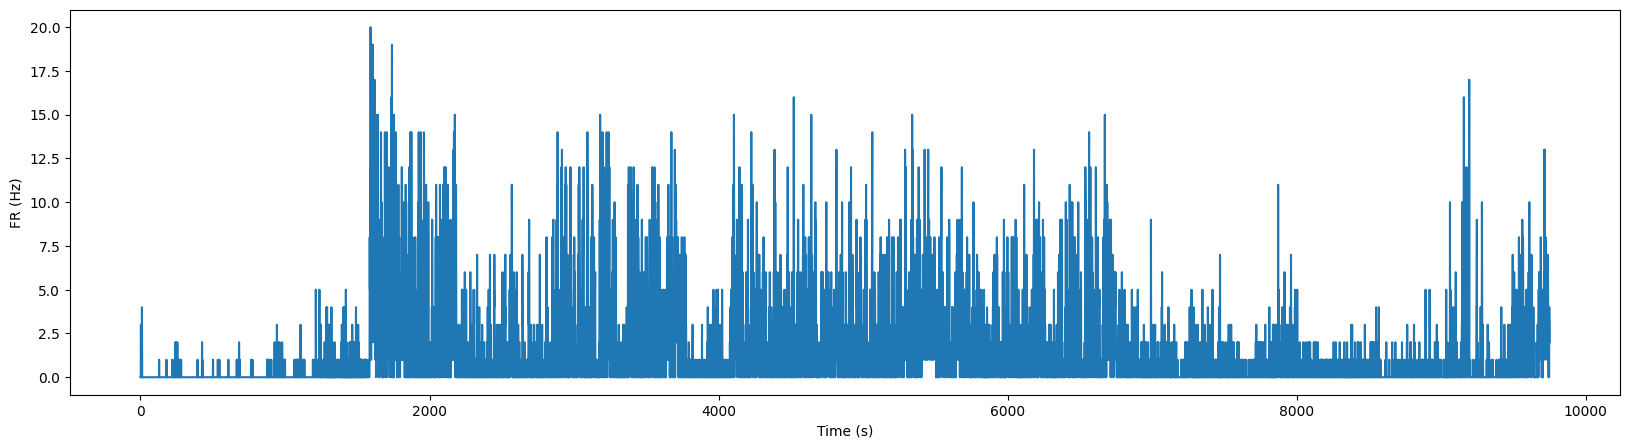

In [39]:
plt.figure(figsize=(20,5))
plt.plot(binned_spikes)
plt.xlabel("Time (s)")
plt.ylabel("FR (Hz)")

:::{admonition} Example: Plot firing rates for units in V1
 Now let's do this for up to 50 units in V1. Make an array of the binned activity of all units in V1 called 'v1_binned'. We'll use this again later.
:::

In [40]:
v1_units = session.units[session.units.ecephys_structure_acronym=='VISp']
numunits = len(v1_units)
if numunits>50:
    numunits=50
v1_binned = np.empty((numunits, numbins))
for i in range(numunits):
    unit_id = v1_units.index[i]
    spikes = spike_times[unit_id]
    for j in range(numbins):
        v1_binned[i,j] = len(spikes[(spikes>j)&(spikes<j+1)])

Plot the activity of all the units, one above the other

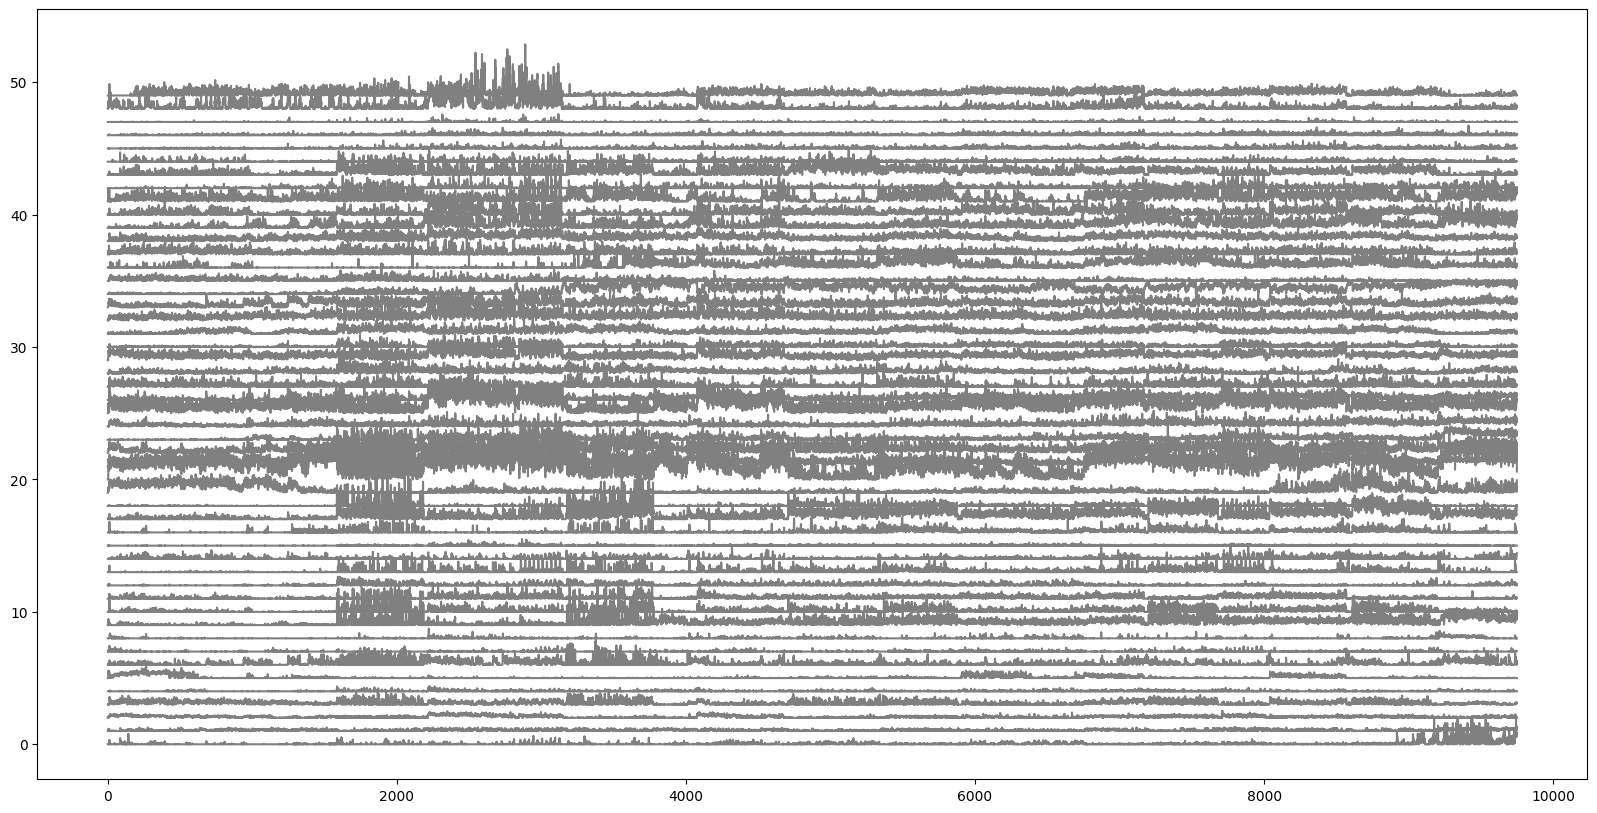

In [41]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(v1_binned[i,:]/30.), color='gray')

### Unit waveforms

For each unit, the average action potential waveform has been recorded from each
channel of the probe. This is contained in the `mean_waveforms` object. This is
the characteristic pattern that distinguishes each unit in spike sorting, and it
can also help inform us regarding differences between cell types.

We will use this in conjuction with the `channel_structure_intervals` function
which tells us where each channel is located in the brain. This will let us get
a feel for the spatial extent of the extracellular action potential waveforms in
relation to specific structures.

:::{admonition} Example: Unit waveforms
Get the waveform for one unit.
:::

In [42]:
waveforms = session.mean_waveforms

What type of object is this?

In [43]:
type(waveforms)

dict

What are the keys?

In [44]:
list(waveforms.keys())[:5]

[951817566, 951817557, 951818568, 951818561, 951818553]

Get the waveform for one unit

In [45]:
unit = session.units.index.values[400]
wf = session.mean_waveforms[unit]

What type of object is this? What is its shape?

In [46]:
type(wf)

xarray.core.dataarray.DataArray

In [47]:
wf.coords

Coordinates:
  * channel_id  (channel_id) int64 850176026 850176028 ... 850176790 850176792
  * time        (time) float64 0.0 3.333e-05 6.667e-05 ... 0.002667 0.0027

In [48]:
wf.shape

(373, 82)

Text(0, 0.5, 'Channel #')

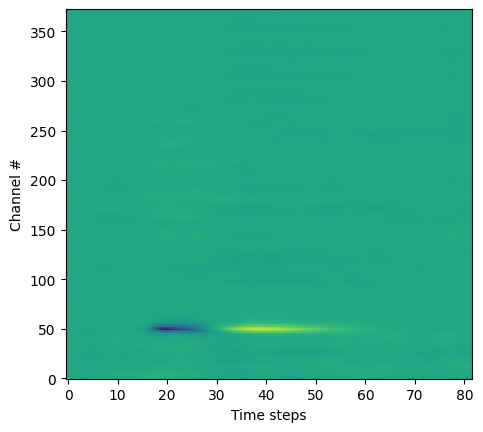

In [49]:
plt.imshow(wf, aspect=0.2, origin='lower')
plt.xlabel('Time steps')
plt.ylabel('Channel #')

:::{admonition} Example: Unit waveforms
Use the `channel_structure_intervals` to get information about where each
channel is located.

We need to pass this function a list of channel ids, and it will identify
channels that mark boundaries between identified brain regions.

We can use this information to add some context to our visualization.
:::

In [50]:
# pass in the list of channels from the waveforms data
ecephys_structure_acronyms, intervals = session.channel_structure_intervals(wf.channel_id.values)
print(ecephys_structure_acronyms)
print(intervals)

['grey' 'VISp' nan]
[  0 204 292 373]


Place tick marks at the interval boundaries, and labels at the interval midpoints.

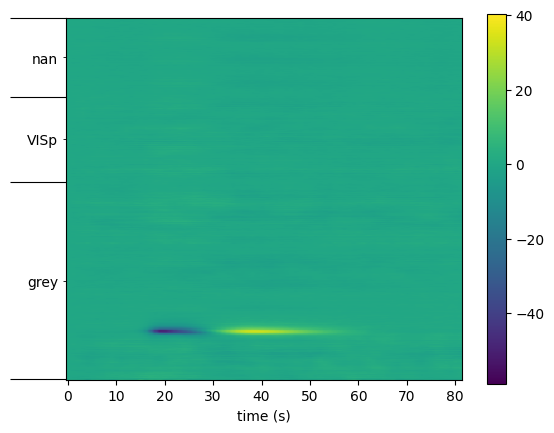

In [51]:
fig, ax = plt.subplots()
plt.imshow(wf, aspect=0.2, origin='lower')
plt.colorbar(ax=ax)

ax.set_xlabel("time (s)")
ax.set_yticks(intervals)
# construct a list of midpoints by averaging adjacent endpoints
interval_midpoints = [ (aa + bb) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(ecephys_structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

plt.show()

Let's see if this matches the structure information saved in the units table:

In [52]:
session.units.loc[unit, "ecephys_structure_acronym"]

'grey'

:::{admonition} Example: Plot the mean waveform for the peak channel for each unit in the dentate gyrus (DG)
 Start by plotting the mean waveform for the peak channel for the unit we just looked at.
Then do this for all the units in DG, making a heatmap of these waveforms
:::

Find the peak channel for this unit, and plot the mean waveform for just that channel

In [53]:
channel_id = session.units.loc[unit, 'peak_channel_id']
print(channel_id)

850176126


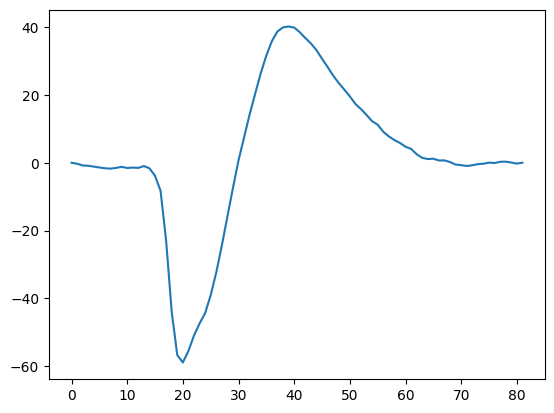

In [54]:
plt.plot(wf.loc[{"channel_id": channel_id}])

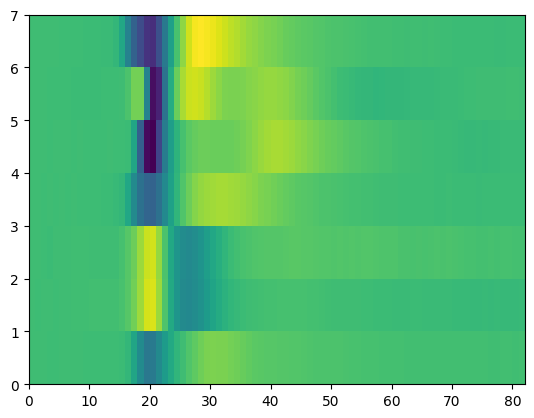

In [55]:
fig, ax = plt.subplots()

th_unit_ids = good_units[good_units.ecephys_structure_acronym=="DG"].index.values

peak_waveforms = []

for unit_id in th_unit_ids:

    peak_ch = good_units.loc[unit_id, "peak_channel_id"]
    unit_mean_waveforms = session.mean_waveforms[unit_id]

    peak_waveforms.append(unit_mean_waveforms.loc[{"channel_id": peak_ch}])


time_domain = unit_mean_waveforms["time"]

peak_waveforms = np.array(peak_waveforms)
plt.pcolormesh(peak_waveforms)

## Stimuli

 A variety of visual stimuli were presented throughout the recording session, and the session object contains detailed information about what stimuli were presented when.

:::{admonition} Example: Stimulus
What stimuli were presented in this session? Find the `stimulus_names` for the session.
:::

In [56]:
session.stimulus_names

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

:::{admonition} Example: Stimulus epochs
These stimuli are interleaved throughout the session. We can use the
`stimulus_epochs` to see when each stimulus type was presented. Then we'll add
this to the activity plot we made above.
:::

In [57]:
stimulus_epochs = session.get_stimulus_epochs()
stimulus_epochs

start_time    stop_time    duration        stimulus_name stimulus_block
0     24.343718    84.410468   60.066750          spontaneous           null
1     84.410468   996.405519  911.995051               gabors            0.0
2    996.405519  1285.396908  288.991389          spontaneous           null
3   1285.396908  1583.896304  298.499396              flashes            1.0
4   1583.896304  1585.647748    1.751444          spontaneous           null
5   1585.647748  2185.148542  599.500795    drifting_gratings            2.0
6   2185.148542  2216.174468   31.025925          spontaneous           null
7   2216.174468  2816.676108  600.501640  natural_movie_three            3.0
8   2816.676108  2846.701238   30.025130          spontaneous           null
9   2846.701238  3146.952038  300.250800    natural_movie_one            4.0
10  3146.952038  3176.977098   30.025060          spontaneous           null
11  3176.977098  3776.477932  599.500835    drifting_gratings            5.0
12  3776.477932  4077.729588  301.251655          spontaneous           null
13  4077.729588  4678.231228  600.501640  natural_movie_three            6.0
14  4678.231228  4708.256308   30.025080          spontaneous           null
15  4708.256308  5397.832372  689.576065    drifting_gratings            7.0
16  5397.832372  5398.833208    1.000835          spontaneous           null
17  5398.833208  5879.267878  480.434670      static_gratings            8.0
18  5879.267878  5909.292938   30.025060          spontaneous           null
19  5909.292938  6389.694278  480.401340       natural_scenes            9.0
20  6389.694278  6689.945098  300.250820          spontaneous           null
21  6689.945098  7170.346408  480.401310       natural_scenes           10.0
22  7170.346408  7200.371488   30.025080          spontaneous           null
23  7200.371488  7680.772808  480.401320      static_gratings           11.0
24  7680.772808  7710.797908   30.025100          spontaneous           null
25  7710.797908  8011.048698  300.250790    natural_movie_one           12.0
26  8011.048698  8041.073788   30.025090          spontaneous           null
27  8041.073788  8569.014840  527.941052       natural_scenes           13.0
28  8569.014840  8611.550348   42.535508          spontaneous           null
29  8611.550348  9152.001828  540.451480      static_gratings           14.0

Remake our plot of V1 activity from above, adding this stimulus epoch
information. Shade each stimulus with a unique color. The **plt.axvspan()** is a
useful function for this.

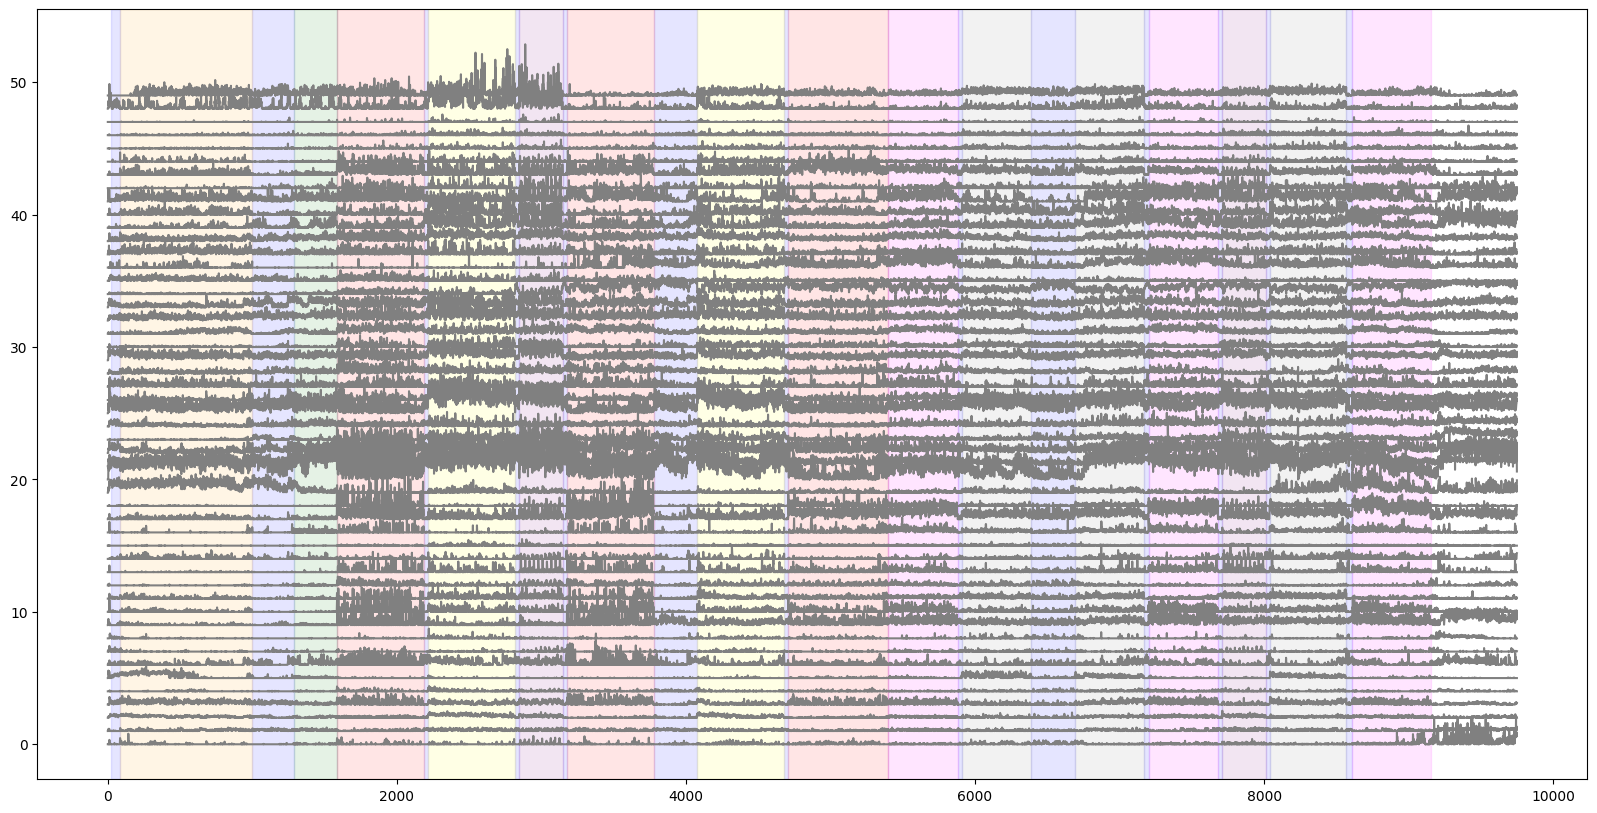

In [58]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(v1_binned[i,:]/30.), color='gray')

colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c, stim_name in enumerate(session.stimulus_names):
    stim = stimulus_epochs[stimulus_epochs.stimulus_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)

Before we dig into the stimulus information in more detail, let's find one more piece of session-wide data that's in the dataset. Running speed.

:::{admonition} Example: Get the running speed
Before we dig further into the stimulus information in more detail, let's add
one more piece of session-wide data to our plot. The mouse's running speed.

Get the `running_speed` and its time stamps from the session object. Plot the
speed as a function of time.
:::

Text(0, 0.5, 'Running speed (cm/s)')

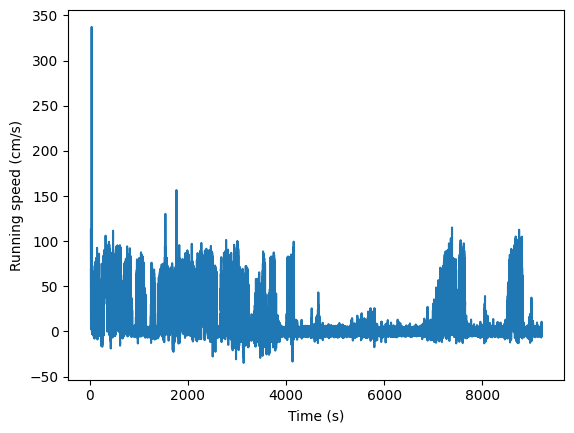

In [59]:
plt.plot(session.running_speed.end_time, session.running_speed.velocity)
plt.xlabel("Time (s)")
plt.ylabel("Running speed (cm/s)")

Add the running speed to the plot of V1 activity and stimulus epochs.

(-10.0, 52.0)

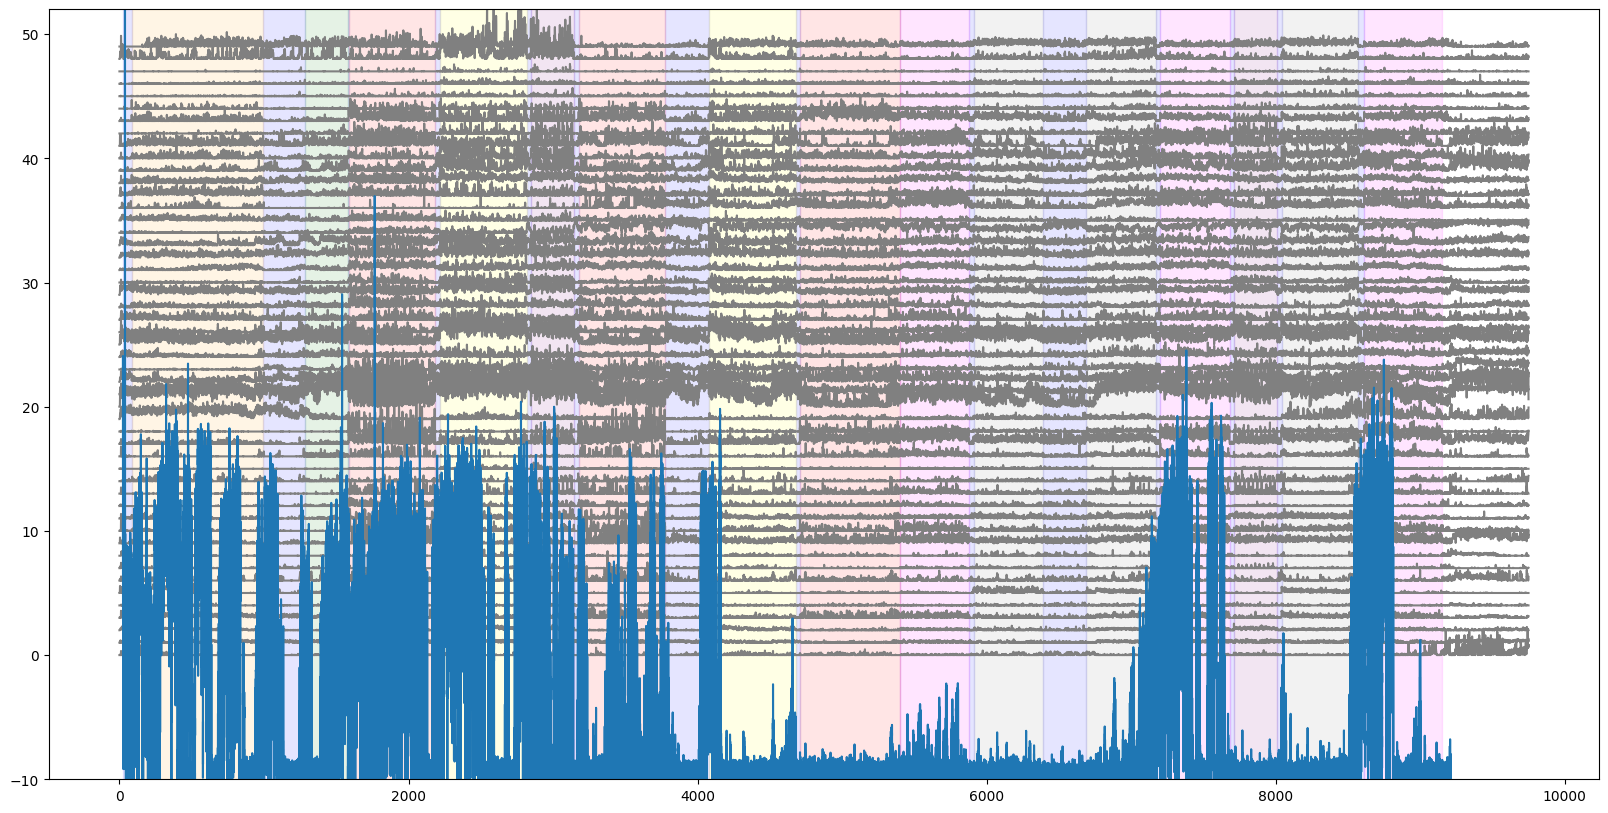

In [60]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(v1_binned[i,:]/30.), color='gray')

#scale the running speed and offset it on the plot
plt.plot(session.running_speed.end_time, (0.3*session.running_speed.velocity)-10)

colors = ['blue','orange','green','red','yellow','purple','magenta','gray','lightblue']
for c, stim_name in enumerate(session.stimulus_names):
    stim = stimulus_epochs[stimulus_epochs.stimulus_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim["start_time"].iloc[j], xmax=stim["stop_time"].iloc[j], color=colors[c], alpha=0.1)

plt.ylim(-10,52)

:::{admonition} Example: Stimulus presentations
Now let's go back and learn more about the stimulus that was presented. The
session object has a function that returns a table for a given stimulus called
`get_stimulus_table`.

Use this to get the stimulus table for drifting gratings and for natural scenes.
What information do these tables provide? How are they different?
:::

In [61]:
stim_table = session.get_stimulus_table(['drifting_gratings'])

In [62]:
stim_table.head()

contrast orientation  \
stimulus_presentation_id                        
3798                          0.8       180.0   
3799                          0.8       225.0   
3800                          0.8       135.0   
3801                          0.8         0.0   
3802                          0.8       315.0   

                                                     phase            size  \
stimulus_presentation_id                                                     
3798                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   
3799                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   
3800                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   
3801                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   
3802                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   

                         spatial_frequency   start_time stimulus_block  \
stimulus_presentation_id                                                 
3798                                  0.04  1585.647748            2.0   
3799                                  0.04  1588.650242            2.0   
3800                                  0.04  1591.652728            2.0   
3801                                  0.04  1594.655252            2.0   
3802                                  0.04  1597.657758            2.0   

                              stimulus_name    stop_time temporal_frequency  \
stimulus_presentation_id                                                      
3798                      drifting_gratings  1587.649398                4.0   
3799                      drifting_gratings  1590.651902                4.0   
3800                      drifting_gratings  1593.654418                2.0   
3801                      drifting_gratings  1596.656912                2.0   
3802                      drifting_gratings  1599.659418               15.0   

                          duration  stimulus_condition_id  
stimulus_presentation_id                                   
3798                       2.00165                    246  
3799                       2.00166                    247  
3800                       2.00169                    248  
3801                       2.00166                    249  
3802                       2.00166                    250

Now get the stimulus table for natural scenes. What is different about these tables?

In [63]:
stim_table_ns = session.get_stimulus_table(['natural_scenes'])

In [64]:
stim_table_ns.head()

frame   start_time stimulus_block   stimulus_name  \
stimulus_presentation_id                                                      
51355                      72.0  5909.292938            9.0  natural_scenes   
51356                      96.0  5909.543151            9.0  natural_scenes   
51357                     109.0  5909.793365            9.0  natural_scenes   
51358                     105.0  5910.043579            9.0  natural_scenes   
51359                      89.0  5910.293792            9.0  natural_scenes   

                            stop_time  duration  stimulus_condition_id  
stimulus_presentation_id                                                
51355                     5909.543151  0.250214                   4908  
51356                     5909.793365  0.250214                   4909  
51357                     5910.043579  0.250214                   4910  
51358                     5910.293792  0.250214                   4911  
51359                     5910.543999  0.250206                   4912

:::{admonition} Example: Drifting gratings stimulus parameters
Use the drifting grating stimulus table to determine what are the unique
parameters for the different stimulus conditions of this stimulus.
:::

In [65]:
stim_table.orientation.unique()

array([180.0, 225.0, 135.0, 0.0, 315.0, 90.0, 270.0, 'null', 45.0],
      dtype=object)

In [66]:
stim_table.spatial_frequency.unique()

array(['0.04', 'null'], dtype=object)

In [67]:
stim_table.temporal_frequency.unique()

array([4.0, 2.0, 15.0, 8.0, 1.0, 'null'], dtype=object)

In [68]:
stim_table.contrast.unique()

array([0.8, 'null'], dtype=object)

What do you think the 'null' conditions are?

:::{admonition} Example: Natural scenes stimulus
Use the stimulus table for natural scenes to find all the times when a
particular image is presented during the session, and add it to the plot of
activity in V1. Pick the first image that was presented in this session.
:::

In [69]:
stim_table_ns[stim_table_ns.frame==stim_table_ns.frame.iloc[0]].head()

frame   start_time stimulus_block   stimulus_name  \
stimulus_presentation_id                                                     
51355                     72.0  5909.292938            9.0  natural_scenes   
51445                     72.0  5931.811770            9.0  natural_scenes   
51493                     72.0  5943.821815            9.0  natural_scenes   
51575                     72.0  5964.338952            9.0  natural_scenes   
51696                     72.0  5994.614226            9.0  natural_scenes   

                            stop_time  duration  stimulus_condition_id  
stimulus_presentation_id                                                
51355                     5909.543151  0.250214                   4908  
51445                     5932.061981  0.250211                   4908  
51493                     5944.072019  0.250204                   4908  
51575                     5964.589161  0.250209                   4908  
51696                     5994.864430  0.250204                   4908

How many times was it presented?

In [70]:
len(stim_table_ns[stim_table_ns.frame==stim_table_ns.frame.iloc[0]])

50

Mark the times when this particular scene was presented on our plot of the activity (without the epochs and running speed).

(5000.0, 9000.0)

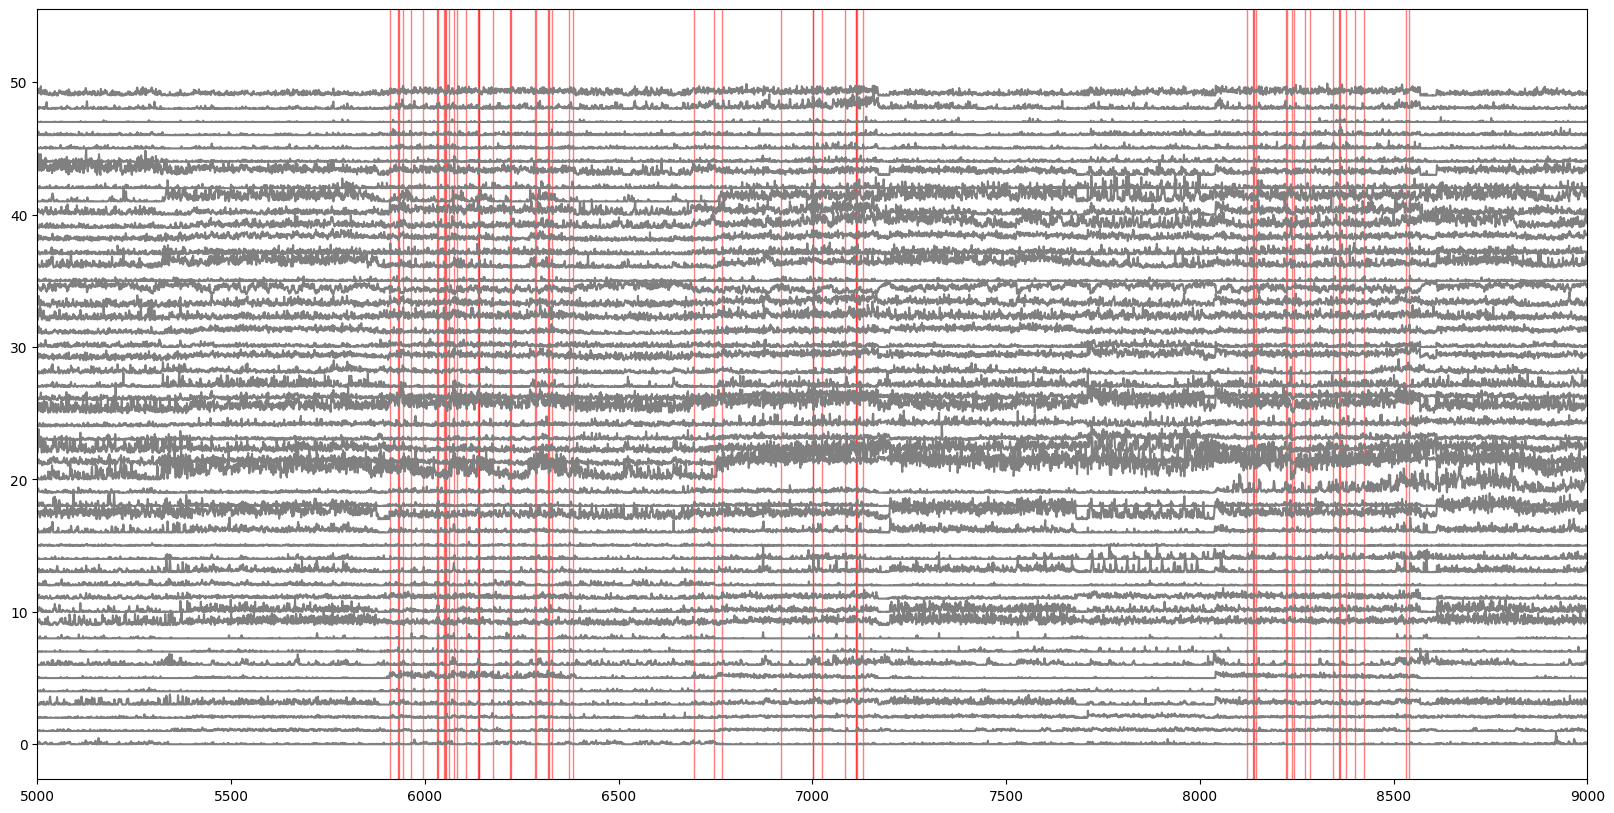

In [71]:
plt.figure(figsize=(20,10))
for i in range(numunits):
    plt.plot(i+(v1_binned[i,:]/30.), color='gray')

stim_subset = stim_table_ns[stim_table_ns.frame==stim_table_ns.frame.iloc[0]]
for j in range(len(stim_subset)):
    plt.axvspan(xmin=stim_subset.start_time.iloc[j], xmax=stim_subset.stop_time.iloc[j], color='r', alpha=0.5)
plt.xlim(5000,9000)

:::{admonition} Example: Stimulus template
 What is this image? The `stimulus template` provides the images and movies that were presented to the mouse. These are only provided for stimuli that are images (natural scenes, natural movies) - parametric stimuli (eg. gratings) do not have templates.
:::

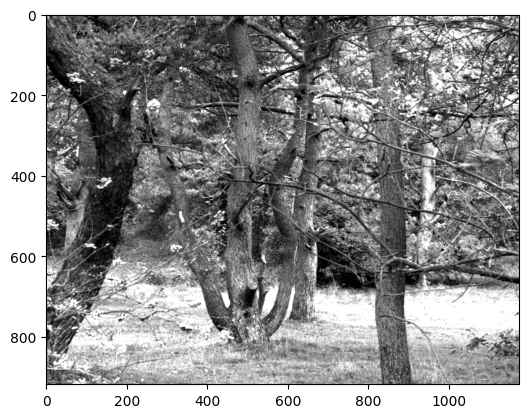

In [72]:
image_num = 96
image_template = cache.get_natural_scene_template(image_num)

plt.imshow(image_template, cmap='gray')

:::{admonition} Example: Single trial raster plots for all units
Now that we've seen the pieces of data, we can explore the neural activity in
greater detail. Make a raster plot for a single presentation of the drifting
grating stimulus at orientation = 45 degrees and temporal frequency = 2 Hz.

To start, make a function to make a raster plot of all the units in the experiment.
:::

In [73]:
def plot_raster(spike_times, start, end):
    num_units = len(spike_times)
    ystep = 1 / num_units

    ymin = 0
    ymax = ystep

    for unit_id, unit_spike_times in spike_times.items():
        unit_spike_times = unit_spike_times[np.logical_and(unit_spike_times >= start, unit_spike_times < end)]
        plt.vlines(unit_spike_times, ymin=ymin, ymax=ymax)

        ymin += ystep
        ymax += ystep


Find the first presentation of our chosen grating condition.

In [74]:
stim_table = session.get_stimulus_table(['drifting_gratings'])
subset = stim_table[(stim_table.orientation==45)&(stim_table.temporal_frequency==2)]
start = stim_table.start_time.iloc[0]
end = stim_table.stop_time.iloc[0]

Use the plot_raster function to plot the response of all units to this trial. Pad the raster plot with half a second before and after the trial, and shade the trial red (with an alpha of 0.1)

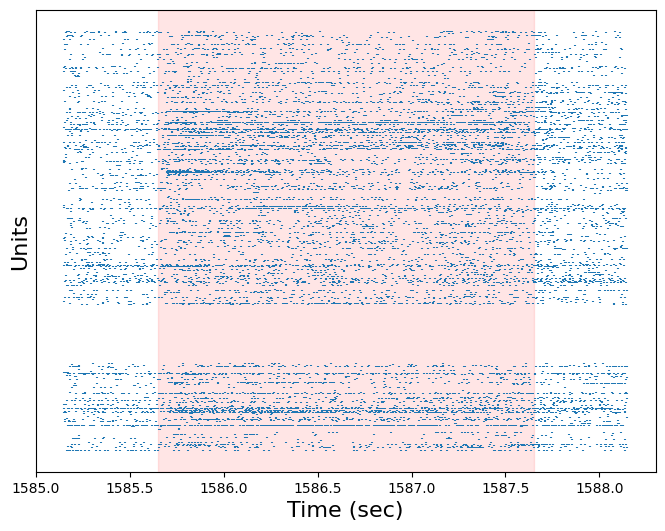

In [75]:
plt.figure(figsize=(8,6))
plot_raster(session.spike_times, start-0.5, end+0.5)
plt.axvspan(start, end, color='red', alpha=0.1)
plt.xlabel('Time (sec)', fontsize=16)
plt.ylabel('Units', fontsize=16)
plt.tick_params(axis="y", labelleft=False, left=False)
plt.show()

:::{admonition} Example: Single trial raster plots for all units
Use the `unit` dataframe to arrange the neurons in the raster plot according to
their overall firing rate.
:::

In [76]:
session.units.sort_values(by="firing_rate", ascending=False).head()

waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
unit_id                                                              
951817746           0.397098          201.534645          0.079703   
951817763           0.512873          126.414405          0.025284   
951826934           0.860666          136.272435          0.030561   
951817924           0.493302          400.143510          0.000030   
951808847           0.191955          216.576945          0.005776   

           cluster_id  cumulative_drift   d_prime  firing_rate  \
unit_id                                                          
951817746          70            169.60  4.684260    66.261032   
951817763          72            240.35  5.139323    59.038540   
951826934         391            110.97  3.144957    51.388427   
951817924          93            203.36  5.187385    48.593865   
951808847          54            127.30  4.795370    48.450483   

           isi_violations  isolation_distance   L_ratio  ...  \
unit_id                                                  ...   
951817746        0.004826           85.556209  0.008705  ...   
951817763        0.004292          116.121088  0.000195  ...   
951826934        0.004762           93.466196  0.003403  ...   
951817924        0.000081           90.534132  0.015623  ...   
951808847        0.012074          125.713434  0.009495  ...   

           ecephys_structure_id  ecephys_structure_acronym  \
unit_id                                                      
951817746                   8.0                       grey   
951817763                   8.0                       grey   
951826934                 402.0                      VISal   
951817924                   8.0                       grey   
951808847                 170.0                        LGd   

           anterior_posterior_ccf_coordinate  dorsal_ventral_ccf_coordinate  \
unit_id                                                                       
951817746                                NaN                            NaN   
951817763                                NaN                            NaN   
951826934                                NaN                            NaN   
951817924                                NaN                            NaN   
951808847                             8029.0                         3711.0   

           left_right_ccf_coordinate  probe_description  \
unit_id                                                   
951817746                        NaN             probeA   
951817763                        NaN             probeA   
951826934                        NaN             probeE   
951817924                        NaN             probeA   
951808847                     8248.0             probeD   

                          location  probe_sampling_rate  \
unit_id                                                   
951817746  See electrode locations         29999.968724   
951817763  See electrode locations         29999.968724   
951826934  See electrode locations         29999.998841   
951817924  See electrode locations         29999.968724   
951808847  See electrode locations         29999.922462   

           probe_lfp_sampling_rate  probe_has_lfp_data  
unit_id                                                 
951817746              1249.998697                True  
951817763              1249.998697                True  
951826934              1249.999952                True  
951817924              1249.998697                True  
951808847              1249.996769                True  

[5 rows x 40 columns]

Text(0.5, 0, 'Unit #')

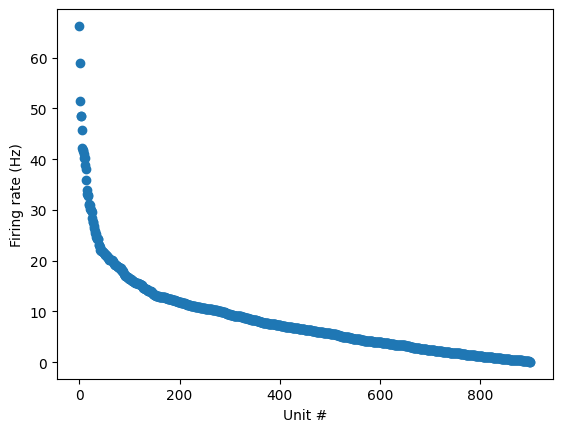

In [77]:
plt.plot(session.units.sort_values(by="firing_rate", ascending=False).firing_rate.values, 'o')
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Unit #")

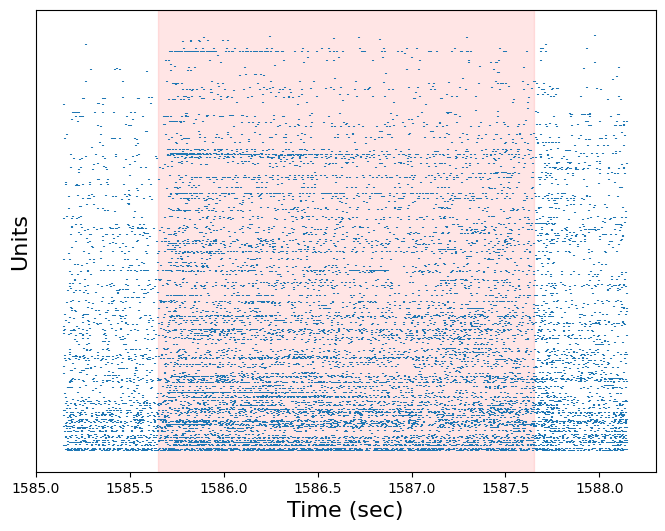

In [78]:
by_fr = session.units.sort_values(by="firing_rate", ascending=False)
spike_times_by_firing_rate = {
    uid: session.spike_times[uid] for uid in by_fr.index.values
}

plt.figure(figsize=(8,6))
plot_raster(spike_times_by_firing_rate, start-0.5, end+0.5)
plt.axvspan(start, end, color='red', alpha=0.1)
plt.ylabel('Units', fontsize=16)
plt.xlabel('Time (sec)', fontsize=16)
plt.tick_params(axis="y", labelleft=False, left=False)
plt.show()

## Stimulus responses

 A lot of the analysis of these data will requires comparing responses of
 neurons to different stimulus conditions and presentations. The SDK has
 functions to help access these, sorting the spike data into responses for each
 stimulus presentations and converting from spike times to binned spike counts.
 This spike histogram representation is more useful for many computations, since
 it can be treated as a timeseries and directly averaged across presentations.

The `presentationwise_spike_counts` provides the histograms for specified
stimulus presentation trials for specified units. The function requires
**stimulus_presentation_ids** for the stimulus in question, **unit_ids** for the
relevant units, and **bin_edges** to specify the time bins to count spikes in
(relative to stimulus onset).

The `conditionwise_spike_statistics` creates a summary of specified units
responses to specified stimulus conditions, including the mean spike count,
standard deviation, and standard error of the mean.

:::{admonition} Example: Presentation-wise analysis for drifting gratings
Pick  a specific condition of the drifting grating stimulus and create spike histograms for the units in V1.
Create bins at a 10 ms resolution so we can see dynamics on a fast timescale.
:::

In [79]:
stim_table.head()

contrast orientation  \
stimulus_presentation_id                        
3798                          0.8       180.0   
3799                          0.8       225.0   
3800                          0.8       135.0   
3801                          0.8         0.0   
3802                          0.8       315.0   

                                                     phase            size  \
stimulus_presentation_id                                                     
3798                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   
3799                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   
3800                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   
3801                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   
3802                      [21235.93333333, 21235.93333333]  [250.0, 250.0]   

                         spatial_frequency   start_time stimulus_block  \
stimulus_presentation_id                                                 
3798                                  0.04  1585.647748            2.0   
3799                                  0.04  1588.650242            2.0   
3800                                  0.04  1591.652728            2.0   
3801                                  0.04  1594.655252            2.0   
3802                                  0.04  1597.657758            2.0   

                              stimulus_name    stop_time temporal_frequency  \
stimulus_presentation_id                                                      
3798                      drifting_gratings  1587.649398                4.0   
3799                      drifting_gratings  1590.651902                4.0   
3800                      drifting_gratings  1593.654418                2.0   
3801                      drifting_gratings  1596.656912                2.0   
3802                      drifting_gratings  1599.659418               15.0   

                          duration  stimulus_condition_id  
stimulus_presentation_id                                   
3798                       2.00165                    246  
3799                       2.00166                    247  
3800                       2.00169                    248  
3801                       2.00166                    249  
3802                       2.00166                    250

In [80]:
# specify the time bins in seconds, relative to stimulus onset
time_step = 1/100.
duration = stim_table.duration.iloc[0]
time_domain = np.arange(0, duration+time_step, time_step)
print(time_domain.shape)

(202,)


In [81]:
stim_ids = stim_table[(stim_table.orientation==90)&(stim_table.temporal_frequency==1)].index
print(stim_ids.shape)

(15,)


In [82]:
histograms = session.presentationwise_spike_counts(bin_edges=time_domain,
                                                   stimulus_presentation_ids=stim_ids,
                                                   unit_ids=v1_units.index)

What type of object is this? What is its shape?

In [83]:
type(histograms)

xarray.core.dataarray.DataArray

In [84]:
histograms.shape

(15, 201, 63)

### Xarray

This has returned a new (to this notebook) data structure, the
`xarray.DataArray`. You can think of this as similar to a 3+D
`pandas.DataFrame`, or as a `numpy.ndarray` with labeled axes and indices. See
the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for
more information. In the mean time, the salient features are:

* Dimensions : Each axis on each data variable is associated with a named
  dimension. This lets us see unambiguously what the axes of our array mean.
* Coordinates : Arrays of labels for each sample on each dimension.

xarray is nice because it forces code to be explicit about dimensions and
coordinates, improving readability and avoiding bugs. However, you can always
convert to numpy or pandas data structures as follows:

* to pandas: `histograms.to_dataframe()` produces a multiindexed dataframe
* to numpy: `histograms.values` gives you access to the underlying numpy array


:::{admonition} Example: Plot the unit's response
Plot the response of the first unit to all 15 trials.
:::

Text(0, 0.5, 'Trials')

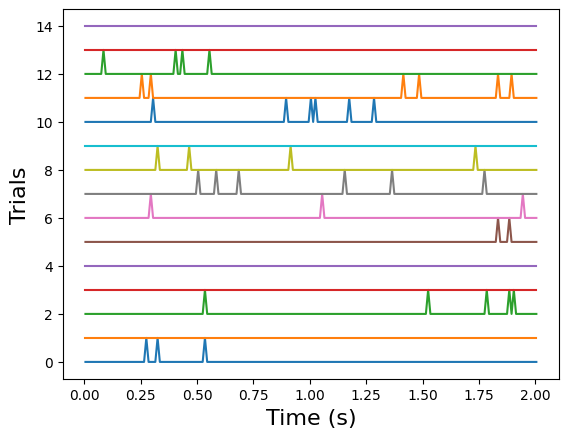

In [85]:
for i in range(15):
    plt.plot(histograms.time_relative_to_stimulus_onset, i+histograms[i,:,0])
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Trials", fontsize=16)

:::{admonition} Example: Compute the average response over trials for all units
Plot a heatmap of mean response for all units in V1.
:::

In [86]:
mean_histograms = histograms.mean(dim="stimulus_presentation_id")

In [87]:
mean_histograms.coords

Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 ...
  * unit_id                          (unit_id) int64 951814973 ... 951816492

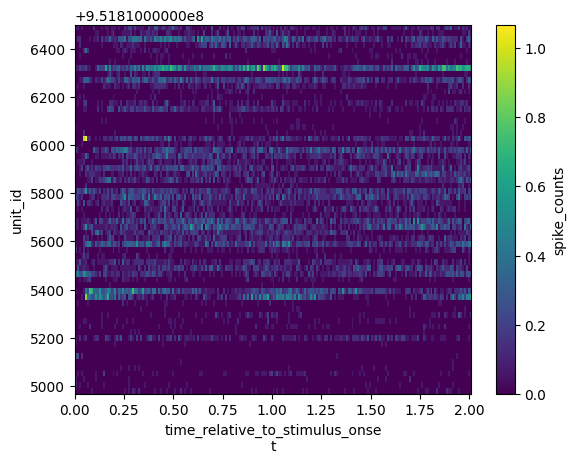

In [88]:
import xarray.plot as xrplot
xrplot.imshow(darray=mean_histograms, x="time_relative_to_stimulus_onset",
                                      y="unit_id")

:::{admonition} Example: Conditionwise analysis
In order to compute a tuning curve that summarizes the responses of a unit to
each stimulus condition of a stimulus, use the `conditionwise_spike_statistics`
to summarize the activity of specific units to the different stimulus
conditions.
:::

In [89]:
stim_ids = stim_table.index.values

In [90]:
dg_stats = session.conditionwise_spike_statistics(stimulus_presentation_ids=stim_ids, unit_ids=v1_units.index)

What type of object is this? What is its shape?

In [91]:
type(dg_stats)

pandas.core.frame.DataFrame

In [92]:
dg_stats.shape

(2583, 5)

What are its columns?

In [93]:
dg_stats.columns

Index(['spike_count', 'stimulus_presentation_count', 'spike_mean', 'spike_std',
       'spike_sem'],
      dtype='object')

Can you explain the first dimension?

In [94]:
dg_stats.head()

spike_count  stimulus_presentation_count  \
unit_id   stimulus_condition_id                                             
951814973 246                             54                           15   
951814989 246                             32                           15   
951815078 246                            150                           15   
951815103 246                             18                           15   
951815110 246                             17                           15   

                                 spike_mean  spike_std  spike_sem  
unit_id   stimulus_condition_id                                    
951814973 246                      3.600000   7.048809   1.819995  
951814989 246                      2.133333   2.614975   0.675184  
951815078 246                     10.000000   8.912271   2.301138  
951815103 246                      1.200000   1.971222   0.508967  
951815110 246                      1.133333   2.065591   0.533333

:::{admonition} Example: Merge the conditionwise statistics with stimulus information
In order to link the stimulus responses with the stimulus conditions, merge the
spike_statistics output with the stimulus table using `pd.merge()`.
:::

In [95]:
dg_stats_stim = pd.merge(
    dg_stats.reset_index().set_index(['stimulus_condition_id']),
    session.stimulus_conditions,
    on=['stimulus_condition_id']
).reset_index().set_index(['unit_id', 'stimulus_condition_id'])

This dataframe currently has a *multi-index*, meaning that each row is indexed
by the pair of unit_id and stimulus_condition_id, rather than a single
identifier. There are several ways to use this index:

* specify the pair of identifiers as a tuple: `dg_stats_stim.loc[(unit_id, stim_id)]`
* specifying the axis makes it easier to get all rows for one unit: `dg_stats_stim.loc(axis=0)[unit_id, :]`
* or you can use `dg_stats_stim.reset_index()` to move the index to regular columns

In [96]:
dg_stats_stim.head()

spike_count  stimulus_presentation_count  \
unit_id   stimulus_condition_id                                             
951814973 246                             54                           15   
951814989 246                             32                           15   
951815078 246                            150                           15   
951815103 246                             18                           15   
951815110 246                             17                           15   

                                 spike_mean  spike_std  spike_sem color  \
unit_id   stimulus_condition_id                                           
951814973 246                      3.600000   7.048809   1.819995  null   
951814989 246                      2.133333   2.614975   0.675184  null   
951815078 246                     10.000000   8.912271   2.301138  null   
951815103 246                      1.200000   1.971222   0.508967  null   
951815110 246                      1.133333   2.065591   0.533333  null   

                                contrast frame  mask opacity orientation  \
unit_id   stimulus_condition_id                                            
951814973 246                        0.8  null  None    True       180.0   
951814989 246                        0.8  null  None    True       180.0   
951815078 246                        0.8  null  None    True       180.0   
951815103 246                        0.8  null  None    True       180.0   
951815110 246                        0.8  null  None    True       180.0   

                                                            phase  \
unit_id   stimulus_condition_id                                     
951814973 246                    [21235.93333333, 21235.93333333]   
951814989 246                    [21235.93333333, 21235.93333333]   
951815078 246                    [21235.93333333, 21235.93333333]   
951815103 246                    [21235.93333333, 21235.93333333]   
951815110 246                    [21235.93333333, 21235.93333333]   

                                           size spatial_frequency  \
unit_id   stimulus_condition_id                                     
951814973 246                    [250.0, 250.0]              0.04   
951814989 246                    [250.0, 250.0]              0.04   
951815078 246                    [250.0, 250.0]              0.04   
951815103 246                    [250.0, 250.0]              0.04   
951815110 246                    [250.0, 250.0]              0.04   

                                     stimulus_name temporal_frequency units  \
unit_id   stimulus_condition_id                                               
951814973 246                    drifting_gratings                4.0   deg   
951814989 246                    drifting_gratings                4.0   deg   
951815078 246                    drifting_gratings                4.0   deg   
951815103 246                    drifting_gratings                4.0   deg   
951815110 246                    drifting_gratings                4.0   deg   

                                x_position y_position    color_triplet  
unit_id   stimulus_condition_id                                         
951814973 246                         null       null  [1.0, 1.0, 1.0]  
951814989 246                         null       null  [1.0, 1.0, 1.0]  
951815078 246                         null       null  [1.0, 1.0, 1.0]  
951815103 246                         null       null  [1.0, 1.0, 1.0]  
951815110 246                         null       null  [1.0, 1.0, 1.0]

:::{admonition} Example: Tuning curve
Plot a 2D tuning curve for the first unit, comparing responses across temporal
frequency and orientation.
:::

In [97]:
unit_id = v1_units.index[1]

In [98]:
stim_ids = stim_table.index.values
session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids, drop_nulls=True)

{'contrast': array([0.8], dtype=object),
 'orientation': array([180.0, 225.0, 135.0, 0.0, 315.0, 90.0, 270.0, 45.0], dtype=object),
 'phase': array(['[21235.93333333, 21235.93333333]'], dtype=object),
 'size': array(['[250.0, 250.0]'], dtype=object),
 'spatial_frequency': array(['0.04'], dtype=object),
 'temporal_frequency': array([4.0, 2.0, 15.0, 8.0, 1.0], dtype=object)}

In [99]:
orivals = session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids, drop_nulls=True)['orientation']
tfvals = session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids, drop_nulls=True)['temporal_frequency']

In [100]:
response_mean = np.empty((len(orivals), len(tfvals)))
response_sem = np.empty((len(orivals), len(tfvals)))
for i,ori in enumerate(orivals):
    for j,tf in enumerate(tfvals):
        stim_id = stim_table[(stim_table.orientation==ori)&(stim_table.temporal_frequency==tf)].stimulus_condition_id.iloc[0]
        response_mean[i,j] = dg_stats_stim.loc[(unit_id, stim_id)].spike_mean
        response_sem[i,j] = dg_stats_stim.loc[(unit_id, stim_id)].spike_sem

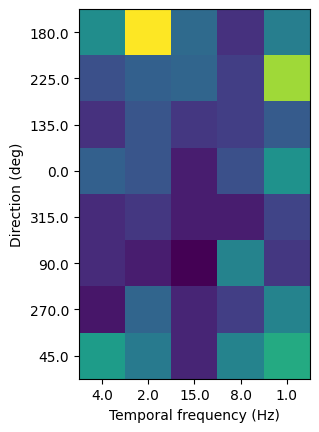

In [101]:
plt.imshow(response_mean)
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Direction (deg)")
plt.xticks(range(5), tfvals)
plt.yticks(range(8), orivals)
plt.show()

## Local Field Potential (LFP)

The final aspect of a Neuropixels probe recording we will investigate is the local field potential (LFP). An LFP signal is a direct recordings of extracellular voltage from which individual spike contributions have been removed by low-pass filtering. The remaining signal reflects the population activity of a large number of cells in the vicinity of the probe, primarily through the electrical field effects of synaptic currents (along with other trans-membrane currents).


LFP can be especially informative for understanding rhythmic activity or oscillations in neural circuits, which can be identified by some simple time-series analysis of the LFP signals.

:::{admonition} Example: Accessing LFP data
We'll start by loading the LFP data from one of the probes in our session, using the `get_lfp` function.

We need to provide this function with a probe id, which we can pull out of the `session.probes` table.

(Note that the "id" column is the index of the dataframe, and thus must be accessed differently than other columns.)
:::

In [102]:
probe_id = session.probes.index[0]
lfp = session.get_lfp(probe_id)
print(lfp)

<xarray.DataArray 'LFP' (time: 12183127, channel: 89)>
array([[ 1.94999993e-05,  1.52100001e-05,  1.63799996e-05, ...,
         1.94999998e-07,  4.68000007e-06,  6.43500016e-06],
       [ 2.28150002e-05,  5.84999998e-06, -1.20899995e-05, ...,
         8.58000021e-06,  1.20899995e-05,  1.65750007e-05],
       [-1.28700003e-05, -3.45150002e-05, -2.90549997e-05, ...,
        -1.75499997e-06,  1.30649996e-05,  7.60500006e-06],
       ...,
       [ 5.67450006e-05,  8.17050022e-05,  8.03399962e-05, ...,
         1.48199997e-05,  8.96999973e-06, -5.26499980e-06],
       [ 5.26500007e-05,  6.88349974e-05,  5.46000010e-05, ...,
         1.01400001e-05,  5.46000001e-06, -4.68000007e-06],
       [ 3.50999981e-05,  3.72450013e-05,  3.93900009e-05, ...,
         7.80000028e-06,  7.01999988e-06, -6.23999995e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 3.788 3.788 3.789 ... 9.75e+03 9.75e+03 9.75e+03
  * channel  (channel) int64 850178710 850178718 ... 850179406 850179414


:::{admonition} Example: Plot the LFP data array
To visualize this data, we'll first use the built-in xarray plotting to generate
a quick plot. This is too much data to plot all at once, so we select a subset
first. Just as in pandas, we use the `loc` property, but since xarray has named
dimensions, we can specify our selections by name rather than by order, using a
dict.

We'll also add the structure boundaries to this plot, as we did with unit waveforms.
:::

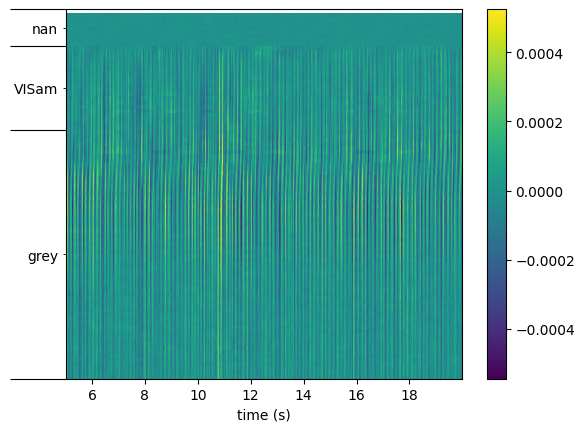

In [103]:
fig, ax = plt.subplots()
lfp_plot = lfp.loc[dict(time=slice(5,20))]
x, y = lfp_plot.time, range(len(lfp_plot.channel))
plt.pcolormesh(x, y, lfp_plot.values.T)
plt.colorbar(ax=ax)

ax.set_xlabel("time (s)")

# include the structure data
ecephys_structure_acronyms, intervals = session.channel_structure_intervals(lfp.channel.values)
ax.set_yticks(intervals)
interval_midpoints = [ (aa + bb) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(ecephys_structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)
plt.show()

:::{admonition} Example: Plot and filter single-channel LFP timeseries
Let's look at the low frequency potentials (LFP) for these data.
:::

We'll start by plotting the timeseries of a single channel.

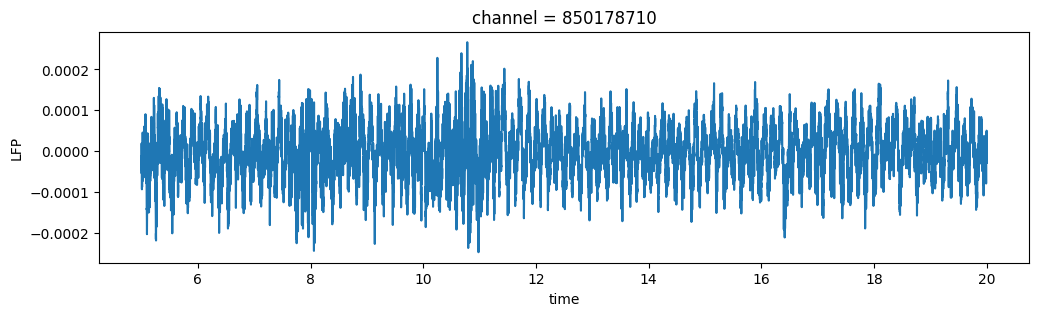

In [104]:
channel = lfp.channel[0]
lfp_subset = lfp.loc[dict(channel=channel, time=slice(5,20))]

# you might then want to clear the full LFP from memory if not using it
# lfp = None

plt.figure(figsize=(12,3))
lfp_subset.plot()
plt.show()

We might also want to visualize a specific frequency band by filtering. To do this we'll want to convert our data into standard numpy arrays for easier processing using the DataArray object's `values` property.

In [105]:
t = lfp_subset.time.values
v = lfp_subset.values

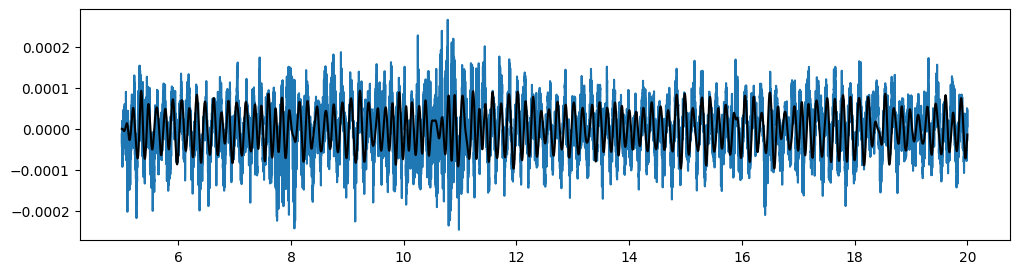

In [106]:
import scipy.signal
freq_window = (4, 10)
filt_order = 3
fs = 1/(t[1]-t[0])
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)
v_alpha = scipy.signal.lfilter(b, a, v)

plt.figure(figsize=(12,3))
plt.plot(t, v)
plt.plot(t, v_alpha,'k')

:::{admonition} Example: LFP Power spectral density (PSD)
Next we're going to analyze some spectral properties of this signal using the
`scipy.signal` library. "Spectral" refers to decomposing a signal into a sum of
simpler components identified by their frequencies. The set of frequencies of
the components forms a *spectrum* that tells us about the complete signal. You
can see a full list of spectral analysis functions in scipy here:
https://docs.scipy.org/doc/scipy/reference/signal.html#spectral-analysis
:::

We first import the package, and inspect the `periodogram` function, which estimates the size of the different frequency components of the signal.

In [107]:
import scipy.signal
help(scipy.signal.periodogram)

Help on function periodogram in module scipy.signal._spectral_py:

periodogram(x, fs=1.0, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)
    Estimate power spectral density using a periodogram.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length must be nperseg. Defaults
        to 'boxcar'.
    nfft : int, optional
        Length of the FFT used. If `None` the length of `x` will be
        used.
    detrend : str or function 

There are a number of options that we won't go into here for refining the analysis. The one piece of information we do need is `fs`, the sampling frequency. If we used the default value `fs=1.0` our results would not match the true frequencies of the signal.

In [108]:
fs = 1/(t[1]-t[0])

f, psd = scipy.signal.periodogram(v, fs)

We'll plot the power spectrum on a semilog plot, since power can vary over many orders of magnitude across frequencies.

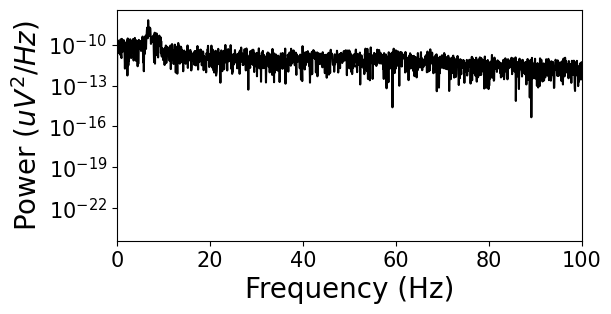

In [109]:
plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,100))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.show()

We see that this representation of the power spectrum is extremely noisy. Luckily, many people have come up with solutions to this problem. Scipy includes a function for Welch's method, which averages out noise by computing many estimates of the power spectrum from overlapping windows of the data. You can find some more references for this approach in the Scipy documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch

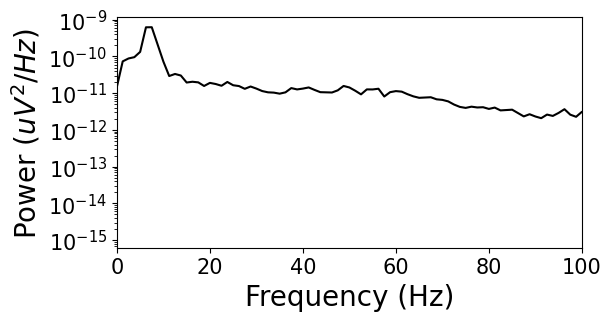

In [110]:
f, psd = scipy.signal.welch(v, fs, nperseg=1000)

plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,100))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)
plt.show()

:::{admonition} Example: Calculate and plot the time-frequency profile ("spectrogram")
We might also be interested in how the frequency content of the signal varies
over time. In a neural context, power in different frequency bands is often
linked to specific types of processing, so we might explore whether changes in
the spectrum coincide with specific behaviors or stimuli.

The *spectrogram* is essentially an estimate of the power spectrum computed in a
sliding time window, producing a 2D representation of the signal power across
frequency and time.
:::

In [111]:
f, t_spec, spec = scipy.signal.spectrogram(v, fs=fs, window='hanning',
                            nperseg=1000, noverlap=1000-1, mode='psd')
# Scipy assumes our signal starts at time=0, so we need to provide the offset
t_spec = t_spec + t[0]

ValueError: Unknown window type.

We'll use the matplotlib `pcolormesh` function to visualize this data as an image. We can pass this function x and y coordinates to get the axis labeling right. We also log-transform the power spectrum and restrict to frequencies less than 100 Hz.

In [ ]:
fmax = 80
x, y = t_spec, f[f<fmax]
plot_data = np.log10(spec[f<fmax])

We'll plot the spectrum together with the raw signal in subplots. Note that we explicitly set the x-axis limits to align the plots. (Alternatively, it's possible to directly couple the limits of different subplots.)

In [ ]:
from matplotlib import cm
plt.figure(figsize=(10,4))

plt.subplot(2,1,1)
plt.pcolormesh(x, y, plot_data, cmap=cm.jet)
window = [5,20]
plt.xlim(window)
plt.ylabel('Frequency (Hz)')

plt.subplot(2,1,2)
plt.plot(t, v, 'k')
plt.xlim(window)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')
plt.show()

## Other resources

These data and the AllenSDK have been documented many times in many places. Here
are some other resource:

* [brain-map.org](https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels)
  * Of particular note is the
  [cheat sheet](https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/0f/5d/0f5d22c9-f8f6-428c-9f7a-2983631e72b4/neuropixels_cheat_sheet_nov_2019.pdf)
    from brain-map.org
* [Allen SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html)
  * The [API documentation of Allen SDK](https://allensdk.readthedocs.io/en/latest/allensdk.brain_observatory.ecephys.html )
* [Notebooks from previous SWDBs](https://github.com/AllenInstitute/swdb_2022/blob/main/DynamicBrain/Visual_Coding_materials/Visual_Coding_Neuropixels_SWDB_2019.ipynb)